# 1. Introduction
***
With the emergence of self-driving cars in the recent years, one can't help but think that the recognition of traffic (or road) signs is one of the most important condition for a self-driving car to drive itself. For instance, if there is an exit that the car needs to take to get you to your destination, it should be able to look at the exit sign and slow down enough to take the lane.

In this work, I will try to create a neural network (NN) which will lead to a classification model where given an image of a road sign, the model will be able to predict accurately what the sign means. But before that, since we know that this is a classification problem and we have the target variable defined, it will be worth our time to check the accuracy of some other, more traditional, classification models as well.

The data was obtained from [Kaggle](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign). The data is that of German traffic (road) signs. There are around 43 classes with more than 50,000 images divided among them. Considering that there is *very* little margin for error since the cars will be on the road, driving themselves (potentially carrying passengers), we will look to obtain a very high accuracy (>95%).


# 2. Data Wrangling
***
### 2.1 Import the necessary modules

In [39]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

### 2.2 Import the data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
meta = pd.read_csv("Meta.csv")

In [3]:
train.head(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png


In [4]:
test.head(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png


It is clear that the train and test dataframes have a column with defined paths, and these paths are for images contained in the train and test folders respectively. 

In [5]:
meta.describe()

,ClassId,ShapeId,ColorId
count,43.000000,43.000000,43.000000
mean,21.000000,0.790698,0.511628
std,12.556539,0.803508,0.935340
min,0.000000,0.000000,0.000000
25%,10.500000,0.000000,0.000000
50%,21.000000,1.000000,0.000000
75%,31.500000,1.000000,1.000000
max,42.000000,4.000000,3.000000


# 3. Exploratory Data Analysis
***

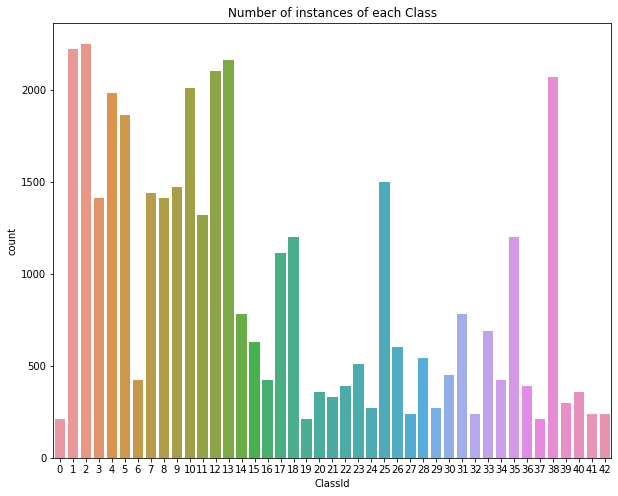

In [6]:
# Check the counts of each class
plt.figure(figsize=(10,8))
sns.countplot(train.ClassId)
plt.title("Number of instances of each Class")
plt.show()

It's pretty clear that the distribution of the target variable (since the class ID is our target) is a little skewed in the training data. However, the distribution is still decent and probably won't affect the ML model.

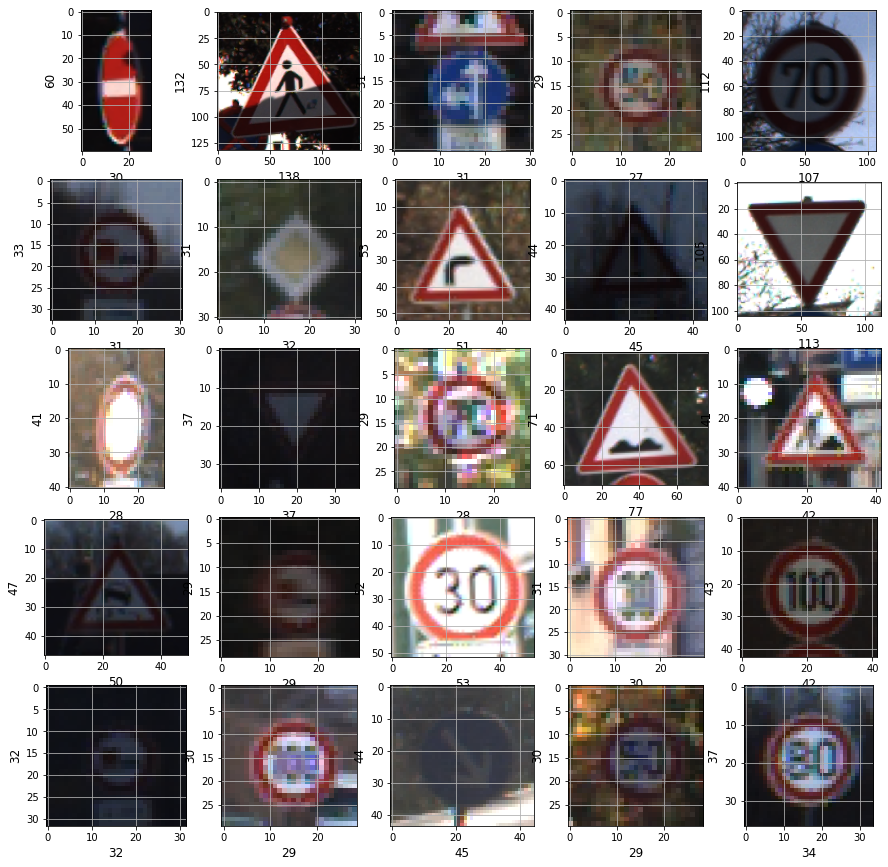

In [7]:
# set the path for train and test images
train_path = "./Train"
test_path = "./Test"

# visualize 25 random images from the train folder
imgs = test["Path"].values

plt.figure(figsize=(15,15))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = './' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 12)
    plt.ylabel(rand_img.shape[0], fontsize = 12)

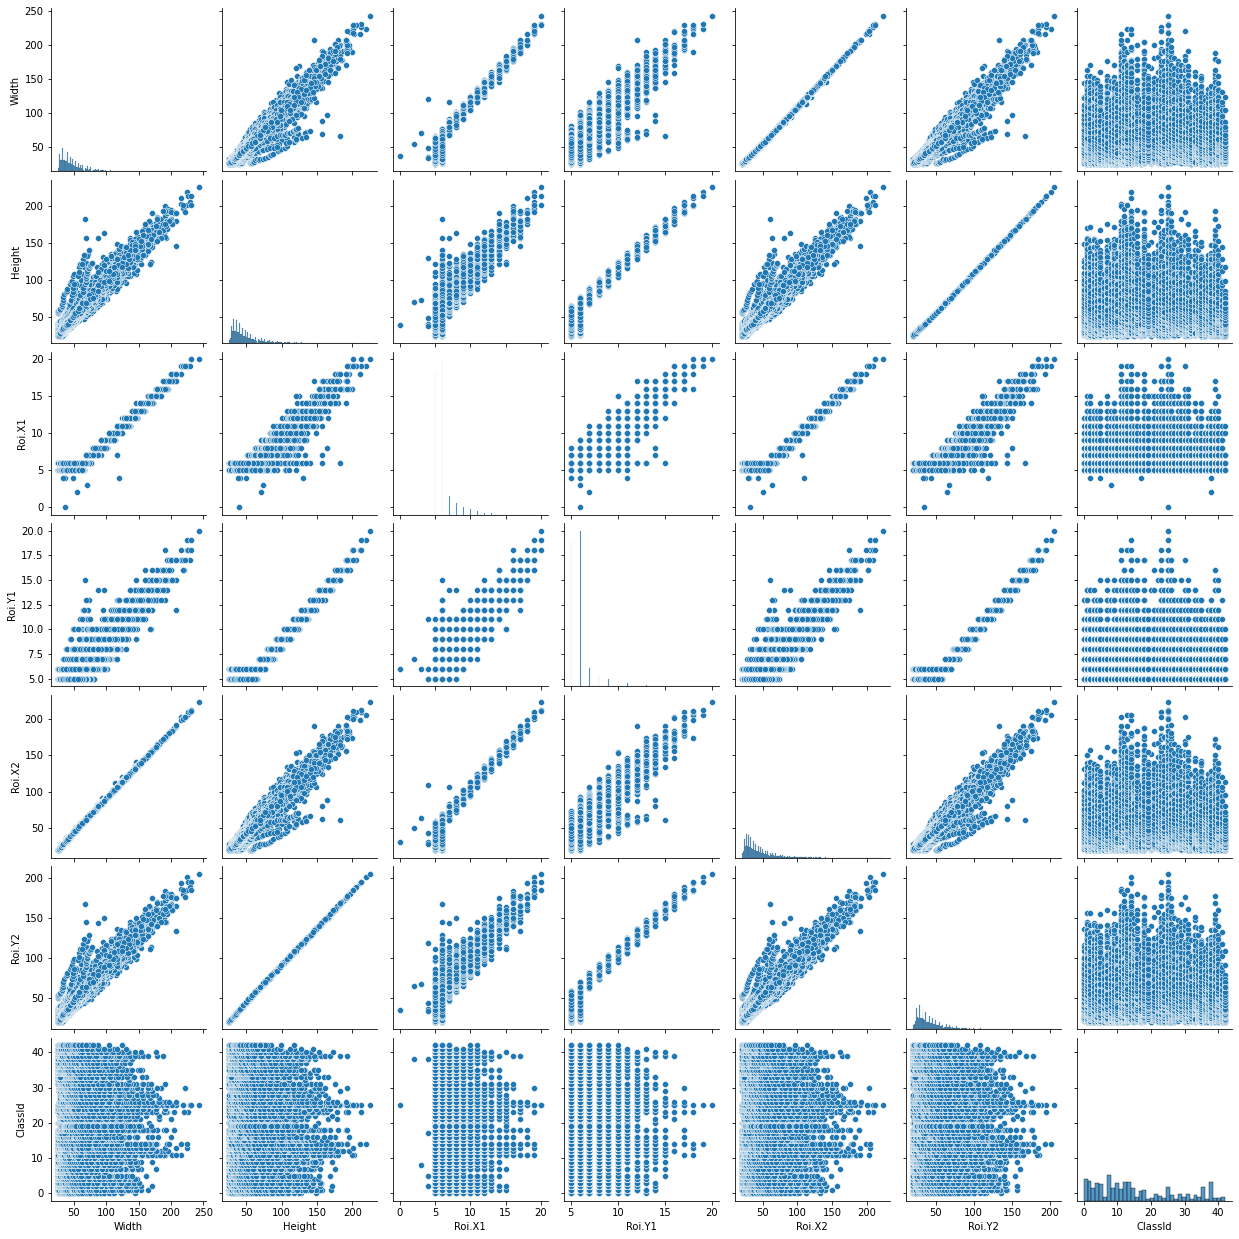

In [8]:
# Plot a pairplot
sns.pairplot(train)
plt.show()

`ROI` in the dataframes is just the region of interest. Let's now see the correlation between the features and the labels (if any present) and visualize it with the help of a heatmap. This will help in feature selection at a later time, if needed.

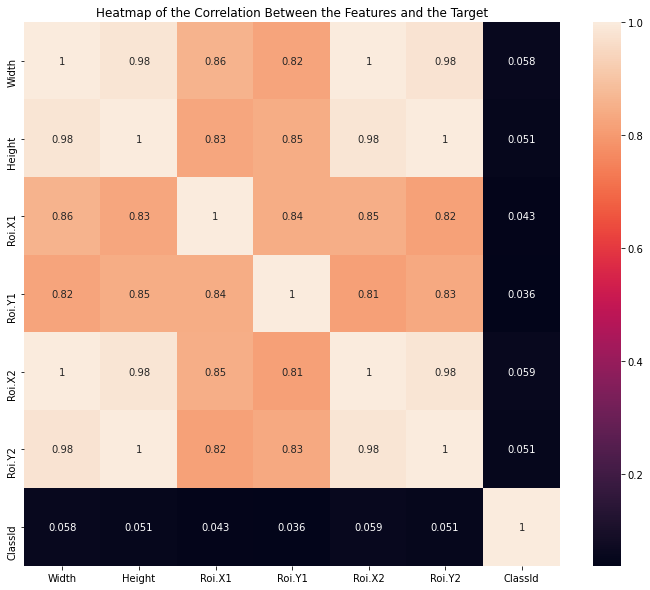

In [9]:
plt.figure(figsize=(12,10))
sns.heatmap(train.corr(), annot=True)
plt.title("Heatmap of the Correlation Between the Features and the Target")
plt.show()

**As expected**, the `Classid` field is not correlated with the features. This is in accordance with the fact that the height, width and region of interest of the images do not determine the Class of the road sign. Let's move on to the next part: Preprocessing the data.


# 3. Pre-processing
***
### 3.1 Convert the images into Numpy arrays

In [11]:
folders_train = [i for i in os.listdir(train_path) if not i.startswith('.')]

# set the labels (classes) and features
feature = []
label = []

# Access each folder and iterate over the images
for folder in folders_train:
    # set the path
    path = os.path.join(train_path, folder)
    # read each image file and resize it to 30*30 array
    images = os.listdir(path)
    for image in images:
        a = Image.open(path + '/' + image)
        a = a.resize((30,30))
        a = np.array(a)
        feature.append(a)
        label.append(folder)
        
# Each folder is the label and the images are the features. All images correspond to the same label.

In [12]:
# Convert the lists (features and labels) into numpy arrays
features = np.array(feature)
labels = np.array(label)

# check the shape of the arrays
print(features.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


### 3.2 Split the data into training and testing sets

In [13]:
# use sklearn's train/test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42)

# check the shape of the data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((29406, 30, 30, 3), (9803, 30, 30, 3), (29406,), (9803,))

### 3.2 One-Hot Encode the labels

In [14]:
# use keras' to_categorical() function
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
y_train.shape

(29406, 43)

After encoding the labels, it's time to now build a sufficiently accurate neural network model.

# 4. Modeling
***


### 4.1 Build the model

In [31]:
# define the model
model = Sequential()

# add the input layer
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=X_train.shape[1:]))

# add hidden layers
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.25))

# add an output layer
model.add(Dense(43, activation='softmax'))

### 4.2 Compile the model

In [32]:
# compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 4.3 Fit the model

In [33]:
# define epochs
epochs = 20

# fit the model
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Train on 29406 samples, validate on 9803 samples
Epoch 1/20
29406/29406 [==============================] - 8s 257us/step - loss: 1.1241 - accuracy: 0.7188 - val_loss: 0.2058 - val_accuracy: 0.9426
Epoch 2/20
29406/29406 [==============================] - 7s 242us/step - loss: 0.2567 - accuracy: 0.9273 - val_loss: 0.1221 - val_accuracy: 0.9671
Epoch 3/20
29406/29406 [==============================] - 7s 248us/step - loss: 0.1697 - accuracy: 0.9518 - val_loss: 0.0954 - val_accuracy: 0.9720
Epoch 4/20
29406/29406 [==============================] - 7s 247us/step - loss: 0.1484 - accuracy: 0.9590 - val_loss: 0.0934 - val_accuracy: 0.9744
Epoch 5/20
29406/29406 [==============================] - 7s 241us/step - loss: 0.1464 - accuracy: 0.9601 - val_loss: 0.0668 - val_accuracy: 0.9828
Epoch 6/20
29406/29406 [==============================] - 7s 244us/step - loss: 0.1292 - accuracy: 0.9642 - val_loss: 0.0623 - val_accuracy: 0.9833
Epoch 7/20
29406/29406 [==============================] - 7s 24

It seems as though this simple convoluted neural network (CNN) model had a validation accuracy of up to 98%. Let's take a deeper look at our simple model.

# 5. Evaluate the model
***

### 5.1 Evaluation metrics

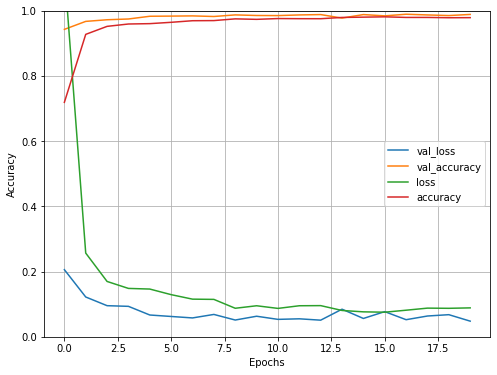

In [34]:
pd.DataFrame(history.history).plot(figsize=(8,6))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

### 5.2 Load test data and run predictions

In [35]:
# define a function that returns the test labels and values
def test_data(file):
    '''Return the labels and the associated files for testing from the csv file'''
    
    y_test = pd.read_csv(file)
    labels_test = y_test['ClassId'].values
    imgs = y_test['Path'].values
    
    data=[]
    
    for img in imgs:
        image = Image.open(img)
        image = image.resize((30,30))
        data.append(np.array(image))
    features_test = np.array(data)
    return features_test, labels_test

In [36]:
# Find the test data and make predictions
features_test, labels_test = test_data("Test.csv")

# make predicitons
labels_predict = model.predict_classes(features_test)
labels_predict

array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

In [37]:
# Find the accuracy of the predictions
print(accuracy_score(labels_predict, labels_test))

0.9563737133808393


In [40]:
# Check the classification report
print(classification_report(labels_predict, labels_test))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93        67
           1       0.97      0.95      0.96       736
           2       0.99      0.93      0.96       797
           3       0.93      0.94      0.93       443
           4       0.97      0.98      0.98       650
           5       0.96      0.92      0.94       654
           6       0.91      1.00      0.95       137
           7       0.93      0.98      0.96       427
           8       0.93      0.96      0.94       437
           9       0.99      0.99      0.99       479
          10       0.98      0.99      0.98       652
          11       0.94      0.96      0.95       409
          12       0.99      0.98      0.98       702
          13       0.99      0.98      0.99       728
          14       0.99      0.99      0.99       269
          15       0.99      1.00      0.99       209
          16       0.99      0.99      0.99       150
          17       0.99    

### 5.3 Visualization of predictions

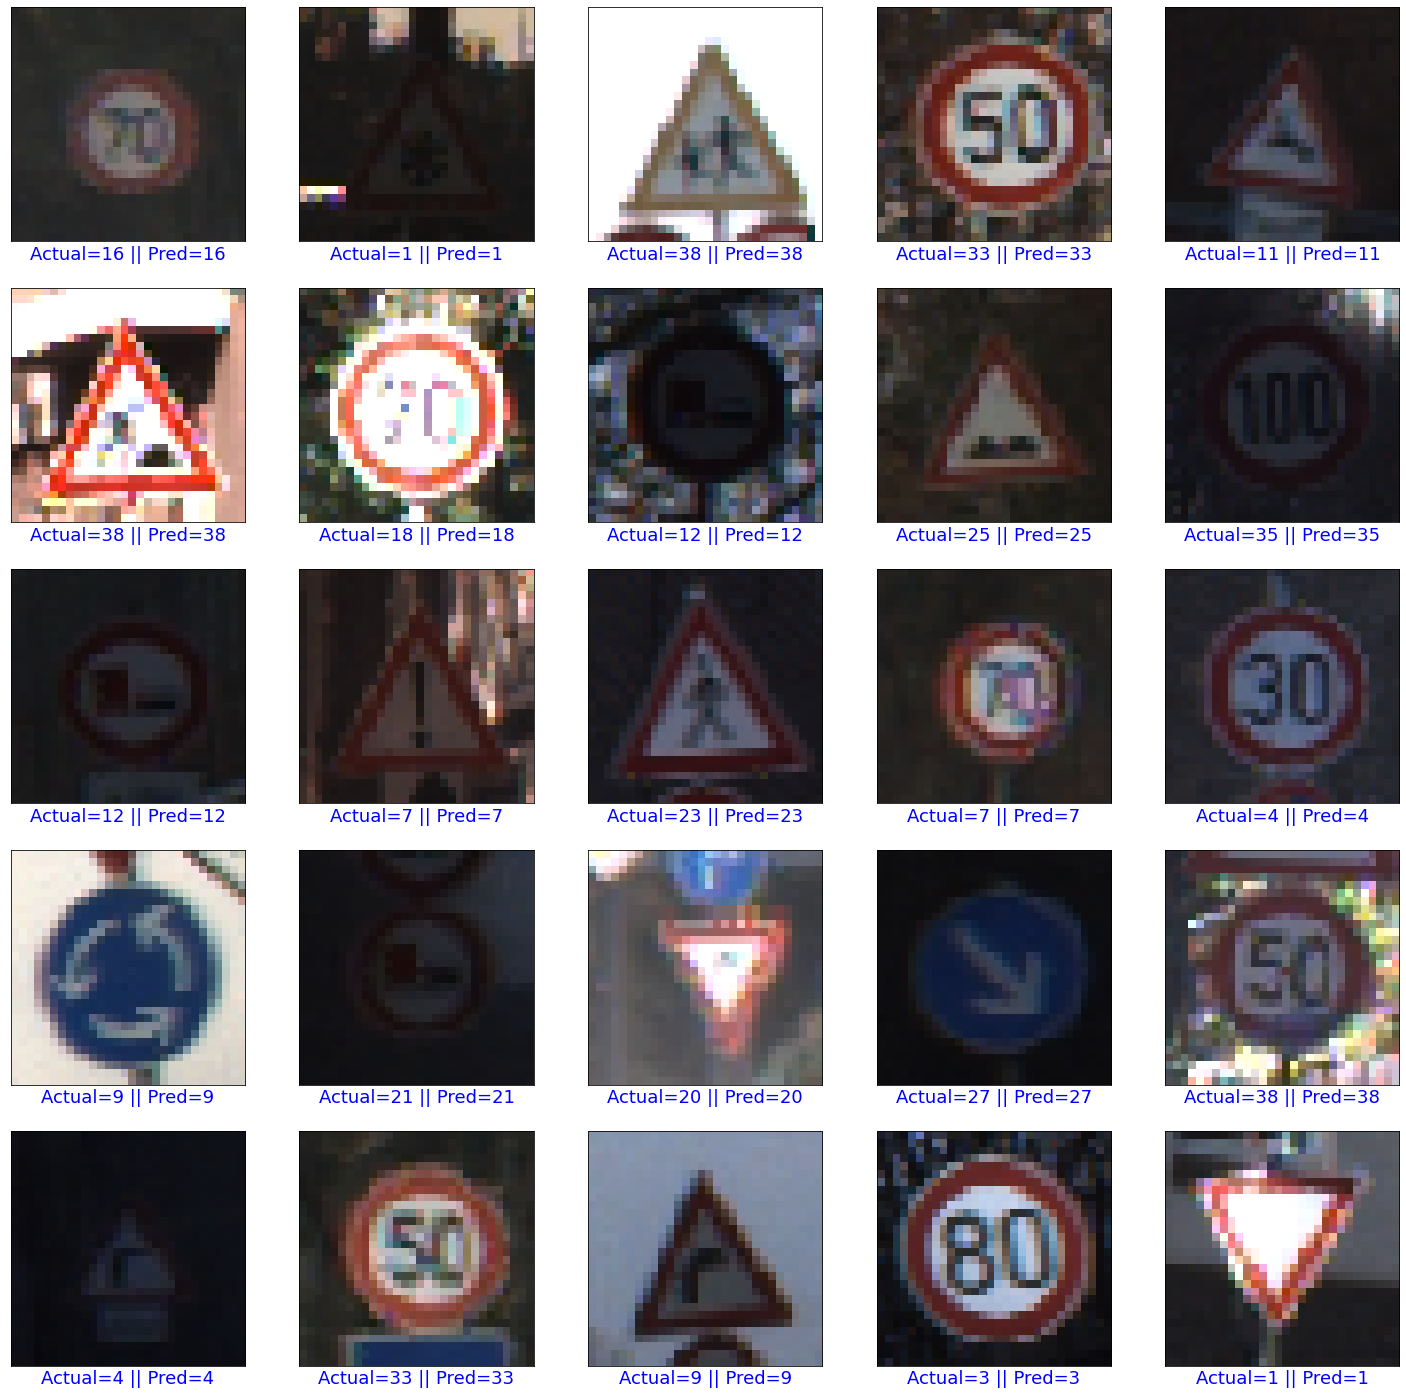

In [44]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = labels_predict[start_index + i]
    actual = labels_test[start_index + i]
    col = 'b'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col, fontsize=18)
    plt.imshow(X_test[start_index + i])
plt.show()

### 5.4. Save the model

In [47]:
# save the model for future use
model.save("./Train/TSR.h5")